# Reading the MUR SST Icechunk Virtual Store with xarray and zarr-python

This notebook demonstrates how to open, subset, and plot the MUR SST virtual dataset using either xarray or zarr-python. Documentation for this dataset can be found [in this design doc](https://github.com/earth-mover/icechunk-nasa/blob/main/design-docs/mursst-virtual-icechunk-store.md).

It also includes a demonstration of visualizing the data with hvplot.

## Step 0. Ensure required version libraries are installed including icechunk > 1.0

In [1]:
%%capture
!pip install icechunk==1.1.5 xarray==2025.9.0 zarr==3.0.8 earthaccess==0.14.0 kerchunk==0.2.8 virtualizarr==1.3.2 fsspec==2025.9.0

In [21]:
pip list | grep -E "zarr|^xarray|virtualizarr|icechunk|kerchunk|boto3|fsspec|boto3|earthaccess"

boto3                         1.40.18
earthaccess                   0.14.0
fsspec                        2025.9.0
icechunk                      1.1.5
kerchunk                      0.2.8
virtualizarr                  1.3.2
xarray                        2025.9.0
zarr                          3.0.8
Note: you may need to restart the kernel to use updated packages.


In [22]:
import boto3
from datetime import datetime, timedelta
import earthaccess
import fsspec
import hvplot.xarray
import holoviews as hv
from holoviews import opts
import matplotlib.pyplot as plt
import numpy as np
import panel as pn

import xarray as xr
import zarr
import icechunk
from icechunk.credentials import s3_credentials

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from typing import Optional

## Step 1. Set zarr runtime configuration

Async and threading operations can be set via zarr.config. Please also see [zarr-python runtime configuration documentation](https://zarr.readthedocs.io/en/stable/user-guide/config.html).

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

The default setting for `threading.max_workers` is `None` so presumably this uses all threads available.

In [23]:
# concurrency=300 seems to be a sweeet spot for smaller EC2s. Fast open time of a few secconds for MUR.
zarr.config.set({
    'async': {'concurrency': 300, 'timeout': None},
    'threading': {'max_workers': 4}
})

## Step 2. Set other variables

In [43]:
bucket_name = 'nasa-eodc-public'
store_name = "MUR-JPL-L4-GLOB-v4.1-virtual-v1"

# Gulf of Tehuantepec, MX
lat_min = 14.
lat_max = 15.
lon_min = -96.
lon_max = -95.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

start_date = '2003-01-01'
end_date = '2012-12-31'
time_range =(start_date, end_date)

lat_min = -90
lon_min = -180
resolution = 0.01
ea_creds = None


## Step 3. Fetch earthaccess credentials

Note: You can skip this step if you have direct bucket access to `s3://podaac-ops-cumulus-protected/`.

In [25]:
earthaccess.login()
ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')

storage_path = "s3://" + bucket_name + "/" + store_name +"/"
print(storage_path)


s3://nasa-eodc-public/MUR-JPL-L4-GLOB-v4.1-virtual-v1/


## Step 4. Initialize the repo

In [26]:
# get_repo subroutine 

def get_repo(bucket_name: str, store_name: str, ea_creds: Optional[dict] = None):
    storage = icechunk.s3_storage(
        bucket=bucket_name,
        prefix=f"icechunk/{store_name}",
        anonymous=True
    )

    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3://podaac-ops-cumulus-protected/", icechunk.s3_store(region="us-west-2")))

    repo_config = dict(
        storage=storage,
        config=config,
    )
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            {"s3://podaac-ops-cumulus-protected/": icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken'] )
            }
        )
        repo_config['authorize_virtual_chunk_access'] = earthdata_credentials
        #repo_config['virtual_chunk_credentials'] = earthdata_credentials

    return icechunk.Repository.open(**repo_config)

In [27]:
repo = get_repo(bucket_name=bucket_name, store_name=store_name, ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

  2025-09-30T00:09:35.186850Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-30T00:09:35.186869Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-30T00:09:35.186874Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-30T00:09:35.186880Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-30T00:09:35.186896Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: Url prefix for s3:// containers must include a host
    at icechunk/src/virtual_chunks.rs:272



## Step 5 Option 1: Read and plot with `xarray`

In [28]:
%%time
mur_ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

CPU times: user 7.39 s, sys: 1.71 s, total: 9.1 s
Wall time: 6.24 s


In [29]:
print(mur_ds)
mur_ds

<xarray.Dataset> Size: 146TB
Dimensions:           (time: 8037, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 64kB 2002-06-01T09:00:00 ... 2024...
Data variables:
    analysed_sst      (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 21TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references: 

<xarray.Dataset> Size: 146TB
Dimensions:           (time: 8037, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 64kB 2002-06-01T09:00:00 ... 2024...
Data variables:
    analysed_sst      (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 21TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [44]:
%%time
#mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).rolling(time=7, center=True).mean().load()
mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="W").mean().load()

CPU times: user 1min 28s, sys: 13.9 s, total: 1min 41s
Wall time: 3min 28s


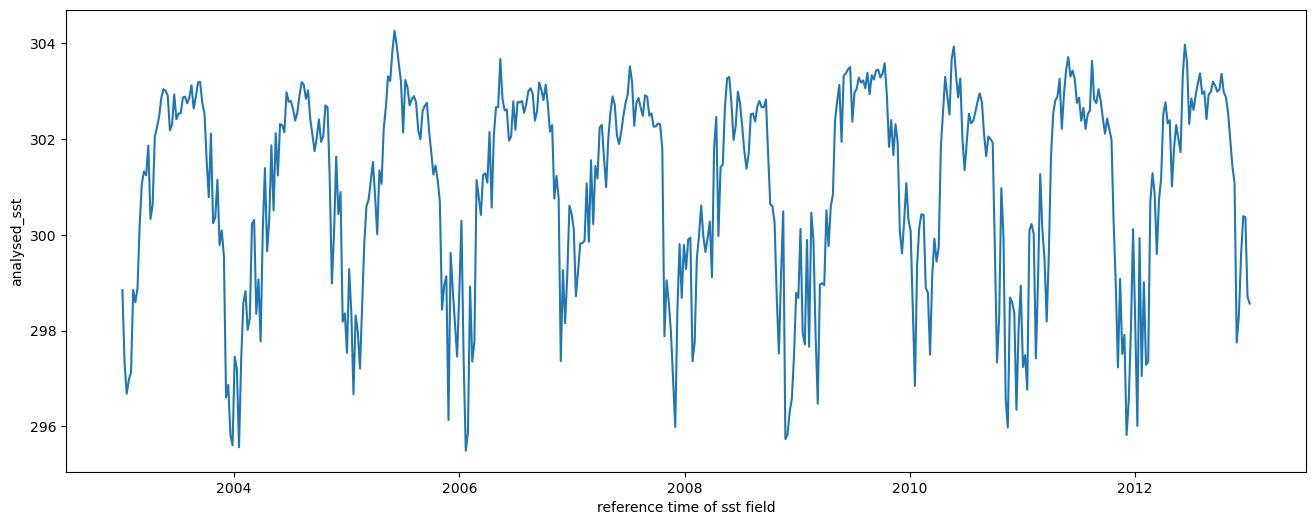

In [45]:
fig = plt.figure(figsize=(16, 6)) 
ax = fig.add_subplot() 
mur_subset.plot()
plt.show()

## Open the PO.DAAC OSTIA VDS created with virtualizarr

In [46]:
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [47]:
%%time
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_s3.json"
ostia_ds = xr.open_dataset(
    vds_link,
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)

CPU times: user 3.8 s, sys: 491 ms, total: 4.29 s
Wall time: 9.41 s


In [48]:
print(ostia_ds)

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST p

In [49]:
%%time
ostia_subset = ostia_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="W").mean().load()

CPU times: user 6min 51s, sys: 8.13 s, total: 6min 59s
Wall time: 5min 54s


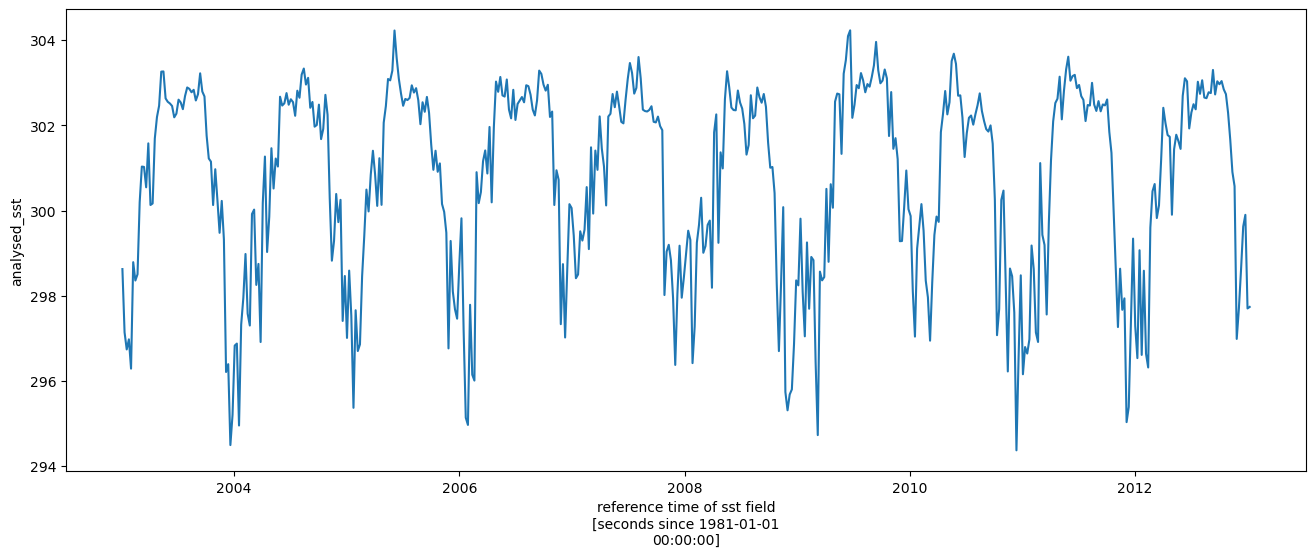

In [50]:
fig = plt.figure(figsize=(16, 6)) 
ax = fig.add_subplot() 
ostia_subset.plot()
plt.show()

## Perform overlploting of MUR vs OSTIA SST

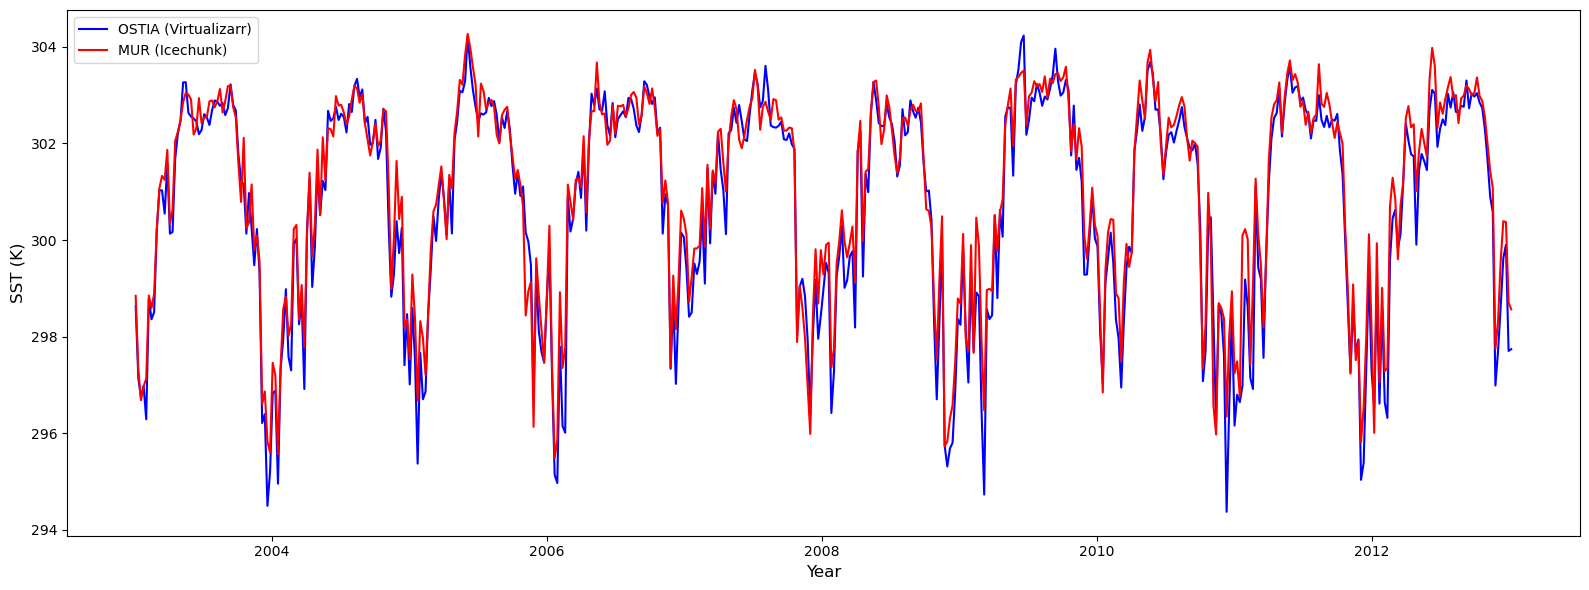

In [51]:
fig = plt.figure(figsize=(16,6), layout="tight")
ax = plt.axes()
plt.plot(ostia_subset["time"].values, ostia_subset, color='blue', label='OSTIA (Virtualizarr)')
plt.plot(mur_subset["time"].values, mur_subset, color='red',label='MUR (Icechunk)' )
plt.xlabel("Year", fontsize=12)
plt.ylabel("SST (K)", fontsize=12)
plt.legend(loc='upper left', )
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()


## Look at the spatial differences in Dec 2003 between the two SST products

In [56]:
%%time
# Define a time slice just in Dec 2004
start_date = '2003-12-01'
end_date = '2003-12-31'
time_range =(start_date, end_date)

# determine the dataset monthly means
# lat/lon ranges remain the same as before, just time range is different
mur_dec2003 = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(dim='time').compute() - 273.15
ostia_dec2003 = ostia_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(dim='time').compute() - 273.15

# do the interpolation of mur grid onto ostia grid
mur_dec2003_on_ostia = mur_dec2003.interp(
    lat=ostia_dec2003.lat,
    lon=ostia_dec2003.lon
)

# find the mean difference
diff_dec2003 = mur_dec2003_on_ostia - ostia_dec2003

CPU times: user 6.14 s, sys: 337 ms, total: 6.48 s
Wall time: 7 s


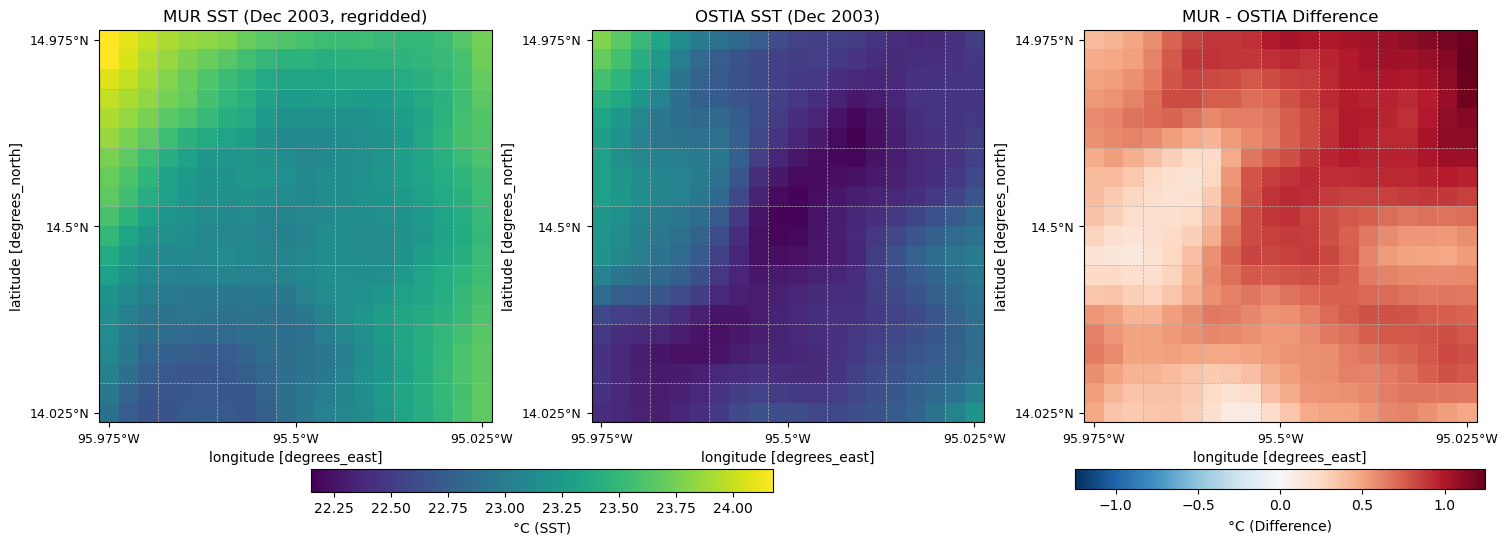

In [57]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Do some plotting
datasets = [
    (mur_dec2003_on_ostia, "MUR SST (Dec 2003, regridded)", "viridis"),
    (ostia_dec2003, "OSTIA SST (Dec 2003)", "viridis"),
    (diff_dec2003, "MUR - OSTIA Difference", "RdBu_r")
]


# Determine color scales
# For the first two (SST-style) datasets, use a common scale
vmin_sst = min(mur_dec2003_on_ostia.min().item(), ostia_dec2003.min().item())
vmax_sst = max(mur_dec2003_on_ostia.max().item(), ostia_dec2003.max().item())

# For difference/third dataset, use symmetric scale around 0
vmax_diff = max(abs(diff_dec2003.min().item()), abs(diff_dec2003.max().item()))

# --- Create figure ---
fig, axes = plt.subplots(
    1, 3, figsize=(18, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

images = []
for ax, (data, title, cmap) in zip(axes, datasets):
    if "MUR - OSTIA Difference" in title:  # Difference map
        im = data.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            cmap=cmap, vmin=-vmax_diff, vmax=vmax_diff,
            add_colorbar=False
        )
    else:
        im = data.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            cmap=cmap, vmin=vmin_sst, vmax=vmax_sst,
            add_colorbar=False
        )
    images.append(im)

        # Coastlines, borders, land
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    
    # Title
    ax.set_title(title, fontsize=12)
    
    # Longitude/latitude ticks with degree symbols
    lon_min, lon_max = float(data.lon.min()), float(data.lon.max())
    lat_min, lat_max = float(data.lat.min()), float(data.lat.max())
    ax.set_xticks(np.linspace(lon_min, lon_max, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(lat_min, lat_max, 3), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=9)
    ax.gridlines(draw_labels=False, linestyle="--", linewidth=0.5)
    
# --- Add colorbars below ---
# Shared colorbar for the first two datasets
cbar_sst = fig.colorbar(
    images[0], ax=axes[:2].ravel().tolist(),
    orientation="horizontal", fraction=0.05, pad=0.1
)
cbar_sst.set_label("°C (SST)")

# Separate colorbar for the third dataset
cbar_diff = fig.colorbar(
    images[2], ax=axes[2], orientation="horizontal", fraction=0.05, pad=0.1
)
cbar_diff.set_label("°C (Difference)")

#plt.tight_layout()
plt.show()  

## Step 5 Option 2: Read and plot with `zarr-python`

This option requires more data formatting steps, but is found to be faster than xarray. 

#### 5a. Open zarr store

In [64]:
%%time
zarr_store = zarr.open(session.store, mode="r")

CPU times: user 3.25 ms, sys: 0 ns, total: 3.25 ms
Wall time: 2.05 ms


#### 5b. Create datetime array for plotting

In [78]:
%%time
epoch = datetime(1981, 1, 1)
dt_array = np.array([epoch + timedelta(seconds=int(t)) for t in zarr_store['time'][:]])

CPU times: user 7.2 s, sys: 1.56 s, total: 8.76 s
Wall time: 4.61 s


#### 5c. Create slice indices from lat and lon ranges

In [66]:
lat_range = list(lat_range)
lon_range = list(lon_range)
lat_indices = [int((lat - lat_min)/resolution) for lat in lat_range]
lon_indices = [int((lon - lon_min)/resolution) for lon in lon_range]

#### 5d. Subset and load data

In [67]:
%%time
sst_subset = zarr_store["analysed_sst"][:, lat_indices[0]:lat_indices[1], lon_indices[0]:lon_indices[1]]
print(f"Fetched {'{:,}'.format(np.prod(sst_subset.shape))} points")

Fetched 80,370,000 points
CPU times: user 2min 58s, sys: 24.7 s, total: 3min 23s
Wall time: 1min 6s


#### 5e. Mask data

In [68]:
%%time
fill_value = zarr_store["analysed_sst"].fill_value
masked_array = np.ma.masked_equal(sst_subset, fill_value)

CPU times: user 38 ms, sys: 56.5 ms, total: 94.5 ms
Wall time: 93.9 ms


#### 5f. Calculate spatial mean over time; add smoothing on a weekly time scale

In [74]:
%%time
sst_mean = masked_array.mean(axis=(1,2))

window_size = 7  #7 days
weights = np.ones(window_size) / window_size
sst_mean = np.convolve(sst_mean, weights, mode='same')

8037
8037
CPU times: user 60.9 ms, sys: 0 ns, total: 60.9 ms
Wall time: 60.6 ms


#### 5g. Scale result and convert to degC

In [75]:
%%time
sst_attrs = zarr_store["analysed_sst"].metadata.attributes
offset, scale = sst_attrs['add_offset'], sst_attrs['scale_factor']
scaled_sst_mean = (sst_mean*scale) + offset - 273.15 

CPU times: user 0 ns, sys: 1.93 ms, total: 1.93 ms
Wall time: 1.54 ms


#### 5h. Plot data

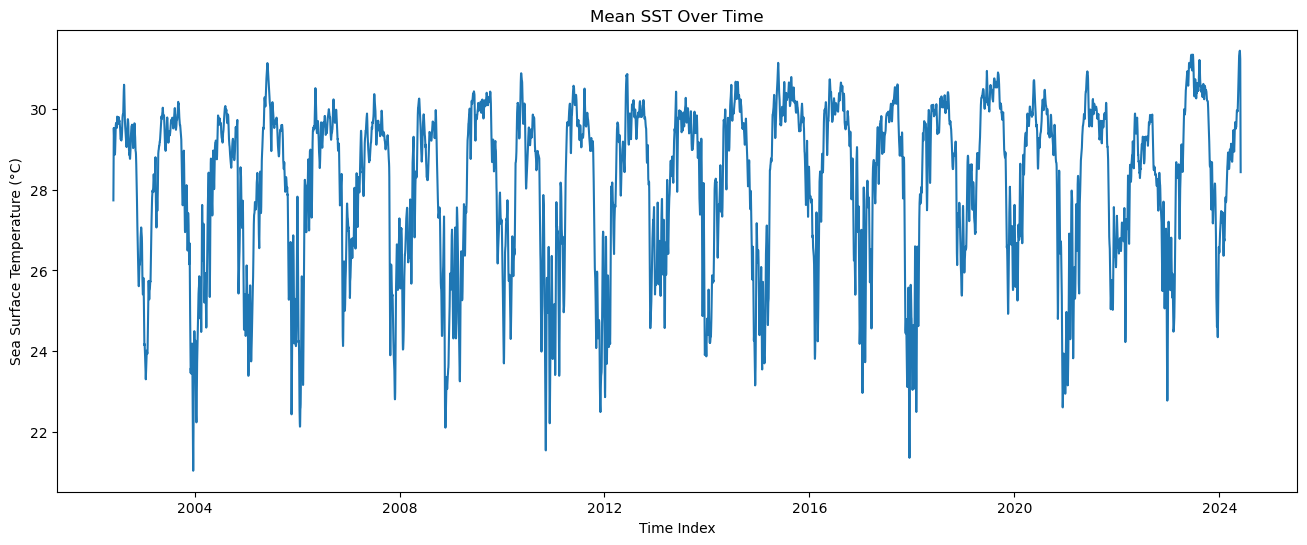

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 176 ms


In [76]:
%%time
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()
plt.plot(dt_array, scaled_sst_mean)
plt.title("Mean SST Over Time")
plt.xlabel("Time Index")
plt.ylabel("Sea Surface Temperature (°C)")  # Replace with correct units
plt.show()

## Step 6: Visualize the data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
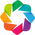

In [31]:
# Enable Panel/HoloViews extensions
hv.extension('bokeh')
pn.extension()

# `masked_array` is from the reading icechunk with zarr-python section
scaled_sst = (masked_array*scale) + offset
shape = scaled_sst.shape

# Get number of time steps
n_times = shape[0]

# Create coordinate arrays
times = zarr_store['time'][:]
# `lat_indices` and `lon_indices` are from the reading icechunk with zarr-python section
lats = zarr_store['lat'][lat_indices[0]:lat_indices[1]]
lons = zarr_store['lon'][lon_indices[0]:lon_indices[1]]

In [32]:
# Create the time index slider
time_slider = pn.widgets.IntSlider(
    name='Time Index', 
    start=0, 
    end=n_times-1, 
    value=0
)

# Create a function to generate the plot for a given time index
def plot_sst(time_idx):
    # Extract the data for the given time step
    time_slice = scaled_sst[time_idx, :, :]
    
    # Format timestamp (adjust based on your time values)
    if isinstance(times[time_idx], np.datetime64):
        time_str = np.datetime_as_string(times[time_idx], unit='D')
    else:
        time_str = f"Step {time_idx}"
    
    # Create a HoloViews Image object
    img = hv.Image((lons, lats, time_slice), kdims=['Longitude', 'Latitude'], vdims=['SST'])
    
    # Apply styling
    img = img.opts(
        opts.Image(
            cmap='turbo',
            colorbar=True,
            clim=(281, 289),
            width=700,
            height=700,
            title=f'Sea Surface Temperature - {time_str}'
        )
    )
    
    return img

# Create a DynamicMap that updates with the slider
dmap = hv.DynamicMap(plot_sst, kdims=['time_idx']).redim.range(time_idx=(0, n_times-1))
# Explicitly bind the DynamicMap to the slider
dmap = dmap.apply(lambda obj: obj.clone(time_idx=time_slider.value))

# Create play/pause widget with a callback to update the slider
player = pn.widgets.Player(
    name='Play',
    start=0,
    end=n_times-1,
    value=0,
    interval=25,  # Update every 200ms - adjust as needed
    loop_policy='loop'
)

# Make sure the player updates the slider, which in turn updates the plot
def update_slider(event):
    time_slider.value = event.new
    
player.param.watch(update_slider, 'value')

# Create a reactive function that outputs a Panel object with the current plot
@pn.depends(time_idx=time_slider)
def get_current_plot(time_idx):
    return plot_sst(time_idx)

# Create the layout
dashboard = pn.Column(
    "## Sea Surface Temperature Time Animation (Direct Zarr)",
    pn.Row(player, time_slider),
    get_current_plot
)

# Display the dashboard
dashboard.servable()

Column
    [0] Markdown(str)
    [1] Row
        [0] Player(end=8036, interval=25, loop_policy='loop', name='Play')
        [1] IntSlider(end=8036, name='Time Index')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)